## Select closest points using CKDTree

To select closest grid points, we will use here one approach using [cKDTree](http://docs.scipy.org/doc/scipy-0.12.0/reference/generated/scipy.spatial.cKDTree.html) class from scipy.spatial package.

Two methods of interpolation are considered here: nearest neighbour and weighting with the inverse of distance squared:

$T_t = frac{\\sum_{i=1}^{m}T_{s,i}w_i}{\\sum_{i=1}^{m}w_i}$, $w_i = 1/d_i^2$).


In [2]:
#for Netcdf manipulation
import xarray as xr

#for array manipulation
import numpy as np
import pandas as pd

#for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt

#for interpolation
from scipy.spatial import cKDTree

D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
D:\Utilisateurs\guillaume\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


First we load Netcdf data.

In [16]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_FWI_Netcdf/ERA5_FWI_QC_SNOW_New_2018_from_3_to_8.nc'
TAS = xr.open_dataset(unique_dataDIR)

In [17]:
lon2d, lat2d = np.meshgrid(TAS.lon, TAS.lat)

In [18]:
class KDTreeIndex():
    
    """ A KD-tree implementation for fast point lookup on a 2D grid
    
    Keyword arguments: 
    dataset -- a xarray DataArray containing lat/lon coordinates
               (named 'lat' and 'lon' respectively)
               
    """
    
    def transform_coordinates(self, coords):
        """ Transform coordinates from geodetic to cartesian
        
        Keyword arguments:
        coords - a set of lan/lon coordinates (e.g. a tuple or 
                 an array of tuples)
        """
        # WGS 84 reference coordinate system parameters
        A = 6378.137 # major axis [km]   
        E2 = 6.69437999014e-3 # eccentricity squared    
        
        coords = np.asarray(coords).astype(np.float)
        
        # is coords a tuple? Convert it to an one-element array of tuples
        if coords.ndim == 1:
            coords = np.array([coords])
        
        # convert to radiants
        lat_rad = np.radians(coords[:,0])
        lon_rad = np.radians(coords[:,1]) 
        
        # convert to cartesian coordinates
        r_n = A / (np.sqrt(1 - E2 * (np.sin(lat_rad) ** 2)))
        x = r_n * np.cos(lat_rad) * np.cos(lon_rad)
        y = r_n * np.cos(lat_rad) * np.sin(lon_rad)
        z = r_n * (1 - E2) * np.sin(lat_rad)
        
        return np.column_stack((x, y, z))
    
    def __init__(self, dataset):
        # store original dataset shape
        self.shape = dataset.shape
        lon2d, lat2d = np.meshgrid(dataset.lon, dataset.lat)
        # reshape and stack coordinates
        coords = np.column_stack((lat2d.ravel(),
                                  lon2d.ravel()))
        
        # construct KD-tree
        self.tree = cKDTree(self.transform_coordinates(coords))
        
    def query(self, point, k):
        """ Query the kd-tree for nearest neighbour.

        Keyword arguments:
        point -- a (lat, lon) tuple or array of tuples
        """
        d, inds  = self.tree.query(self.transform_coordinates(point),k=k)
        w = 1.0 / d**2
        # regrid to 2D grid
        indslatlon = np.unravel_index(inds, self.shape)
        # return DataArray indexers
        return d, inds, w, indslatlon
       # return xr.DataArray(index[0], dims='pixel'), \
       #        xr.DataArray(index[1], dims='pixel')

In [19]:
ground_pixel_tree = KDTreeIndex(TAS.sel(time='2018-08-01').FWI)

In [20]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_shapefile_2018.csv", sep=",")
stations.head()

,NoStation,latD,lonD
0,472,49.2592,-68.1461
1,474,49.6472,-67.6264
2,475,49.1956,-69.4128
3,614,49.3594,-70.9153
4,615,49.6058,-70.1111


## Loop over all stations using stations' index

In [21]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_shapefile_2018.csv", sep=",")
FWI_kpts_model = pd.DataFrame()
for i, row in stations.iterrows(): 
    site = row['latD'], row['lonD']
    d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)
    FWI_kpts = []    
    for day in TAS.time: 
        FWI_kpts.append((np.nansum(w * TAS.sel(time=day).FWI.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0])
    FWI_kpts_model[str(int(row[0]))] = FWI_kpts
    
FWI_kpts_model['Date'] = TAS.time
FWI_kpts_model = FWI_kpts_model.set_index('Date')
FWI_kpts_model.to_csv("K:/PROJETS/PROJET_FIRE_INDEX/Closest_points/FWI_kpts_model_Shapefile_2018.csv", header = True, sep = ',') 
FWI_kpts_model.head()

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Open FWI computed over stations 

In [22]:
dataframe = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_In_curr_Shapefile_FWI_SOPFEU2018.csv", encoding='latin-1')
dataframe = dataframe.set_index('Date')
dataframe.head()

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,0.0,5.9,6.1,0.0,0.0,0.5,1.0,6.0,4.2,0.0,...,5.6,4.2,4.1,3.5,4.3,6.0,2.0,5.3,0.0,7.5
2018-04-02,0.4,14.8,4.4,0.0,0.1,0.8,1.0,5.3,7.7,0.2,...,0.2,0.3,3.3,0.9,3.1,3.5,0.4,0.8,0.0,0.7
2018-04-03,0.6,14.8,4.8,0.2,0.3,0.9,2.2,14.4,9.4,0.2,...,0.5,0.6,5.1,1.6,2.9,3.0,0.7,2.3,0.4,0.9
2018-04-04,0.8,11.7,5.6,0.2,0.1,0.9,2.3,7.9,12.8,0.2,...,0.1,0.5,4.4,1.8,3.7,1.0,0.9,3.0,0.8,0.0
2018-04-05,1.8,9.3,0.0,0.0,0.0,0.0,0.0,8.5,7.2,0.0,...,0.0,0.4,0.1,0.0,2.0,0.0,0.0,0.3,0.8,0.0


## Select time range using ERA5 Onset 

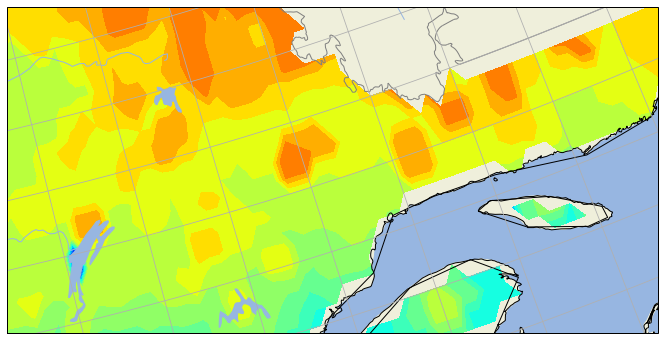

In [23]:
unique_dataDIR = 'K:/PROJETS/PROJET_FIRE_INDEX/ERA5_Onset_Netcdf/ERA5_SNOW_Onset_2018_from_4_to_8.nc'
VAR = xr.open_dataset(unique_dataDIR) 

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-75,-60,50,52])
ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      
ax.add_feature(cfeature.LAND.with_scale('50m'))       
ax.add_feature(cfeature.LAKES.with_scale('50m'))     
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    
ax.add_feature(cfeature.RIVERS.with_scale('50m'))    
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',    
                        facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax.add_feature(states_provinces, edgecolor='gray')

cmap0=plt.cm.jet
cmap0.set_under('darkblue') 
cmap0.set_over('darkred') 

mm = ax.contourf(VAR.lon,\
                   VAR.lat,\
                   VAR.Onset,\
                   vmin=0,\
                   vmax=100, \
                   transform=ccrs.PlateCarree(),\
                   levels=np.arange(0, 100, 5.0),\
                   cmap=cmap0 )
ax.gridlines()

In [24]:
stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_latlon_in_shapefile_2018.csv", sep=",")
ERA5_Onset = []   
for i, row in stations.iterrows(): 
    site = row['latD'], row['lonD']
    d, inds, w, indslatlon = ground_pixel_tree.query(site, k=10)   
    ERA5_Onset.append(int(np.round(np.nansum(w * VAR.Onset.values.flatten()[inds], axis=1) / np.nansum(w, axis=1))[0]))

In [25]:
ERA5_Onset = pd.DataFrame(ERA5_Onset)
ERA5_Onset.head()

,0
0,29
1,51
2,47
3,52
4,58


In [26]:
import datetime
from datetime import timedelta
datetime.date(2018, 4, 1)
ERA5_Onset = pd.DataFrame(ERA5_Onset)
ERA5_Onset['Date'] = ERA5_Onset[0].apply(lambda x: datetime.date(2018, 4, 1) + timedelta(days=x))
ERA5_Onset.head()

,0,Date
0,29,2018-04-30
1,51,2018-05-22
2,47,2018-05-18
3,52,2018-05-23
4,58,2018-05-29


We will filter our dataset using Onset. 

In [27]:
dataframe_stations = pd.read_csv("K:/PROJETS/PROJET_FIRE_INDEX/database_stations/Stations_In_curr_Shapefile_FWI_SOPFEU2018.csv", encoding='latin-1')
dataframe_stations = dataframe_stations.set_index('Date')

i = 0 
for column in dataframe_stations:
    dataframe_stations[column] = dataframe_stations[column].loc[ERA5_Onset['Date'][i].strftime('%Y-%m-%d'):'2018-08-31']
    i+=1
    
i = 0 
for column in FWI_kpts_model:
    FWI_kpts_model[column] = FWI_kpts_model[column].loc[ERA5_Onset['Date'][i].strftime('%Y-%m-%d'):'2018-08-31']
    i+=1

In [29]:
dataframe_stations.to_csv('K:/PROJETS/PROJET_FIRE_INDEX/database_stations/FWI_Stations_Pessamit_2018.csv')

In [30]:
dataframe_stations

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# compute of severity rating SR = 0.0272 * FWI^1.77 
modDfObj = dataframe_stations.apply(lambda x: 0.0272 * np.power(x, 1.77) )
modDfObj.to_csv('K:/PROJETS/PROJET_FIRE_INDEX/database_stations/SR_Stations_Pessamit_2018.csv')

## Make correlation between two DataFrames

In [14]:
FWI_kpts_model

,472,474,475,614,615,621,622,623,632,644,...,669,735,736,747,752,754,763,764,765,766
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_corr_stations_ERA5 = pd.DataFrame()
df_corr_stations_ERA5['Correlation'] = dataframe_stations.corrwith(other=FWI_kpts_model)
df_corr_stations_ERA5['Lat'] = stations.latD.values
df_corr_stations_ERA5['Lon'] = stations.lonD.values
df_corr_stations_ERA5.head()

,Correlation,Lat,Lon
472,0.238178,49.2592,-68.1461
474,0.027844,49.6472,-67.6264
475,0.013303,49.1956,-69.4128
614,0.875703,49.3594,-70.9153
615,0.813583,49.6058,-70.1111


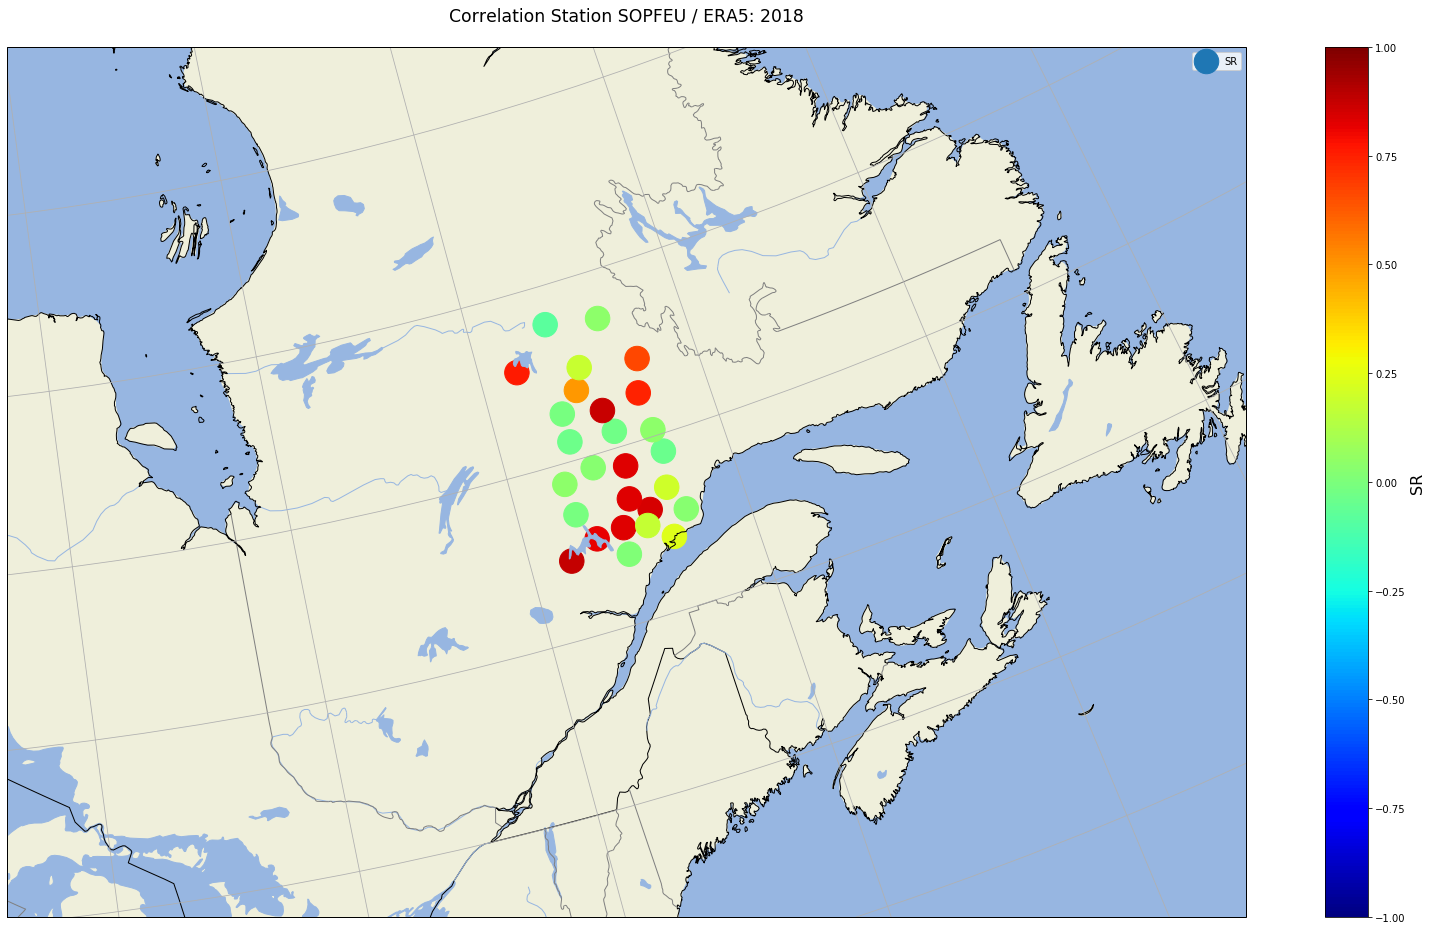

In [16]:
fig=plt.figure(figsize=(28,16), frameon=True) 
ax = plt.subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-85,-55,45,55])
 #ax.coastlines(resolution='110m');
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
  
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche rivières
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',     # ajout de la couche cotière
                            facecolor='none', name='coastline')
ax.add_feature(coast, edgecolor='black')   
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='10m',
            facecolor='none')
   
ax.add_feature(states_provinces, edgecolor='gray')
# Plots the data onto map
plt.scatter(df_corr_stations_ERA5['Lon'], df_corr_stations_ERA5['Lat'], alpha=1.,
            s=600, label="SR",
            c=df_corr_stations_ERA5['Correlation'],
            vmin=-1,
            vmax=1,
            cmap=plt.get_cmap("jet"),
            transform=ccrs.PlateCarree())
       
ax.gridlines()
# Colorbar
fwi = df_corr_stations_ERA5['Correlation']
#tick_values = np.linspace(fwi.min(), fwi.max(), 11)
cbar = plt.colorbar()
#cbar.ax.set_yticklabels(["%d"%(v) for v in tick_values], fontsize=14)
cbar.set_label('SR', fontsize=16)
# Plot labels
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend()
 
string_title=u'Correlation Station SOPFEU / ERA5: 2018\n'
plt.title(string_title, size='xx-large')
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Pessamit_Shapefile_Correlation_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

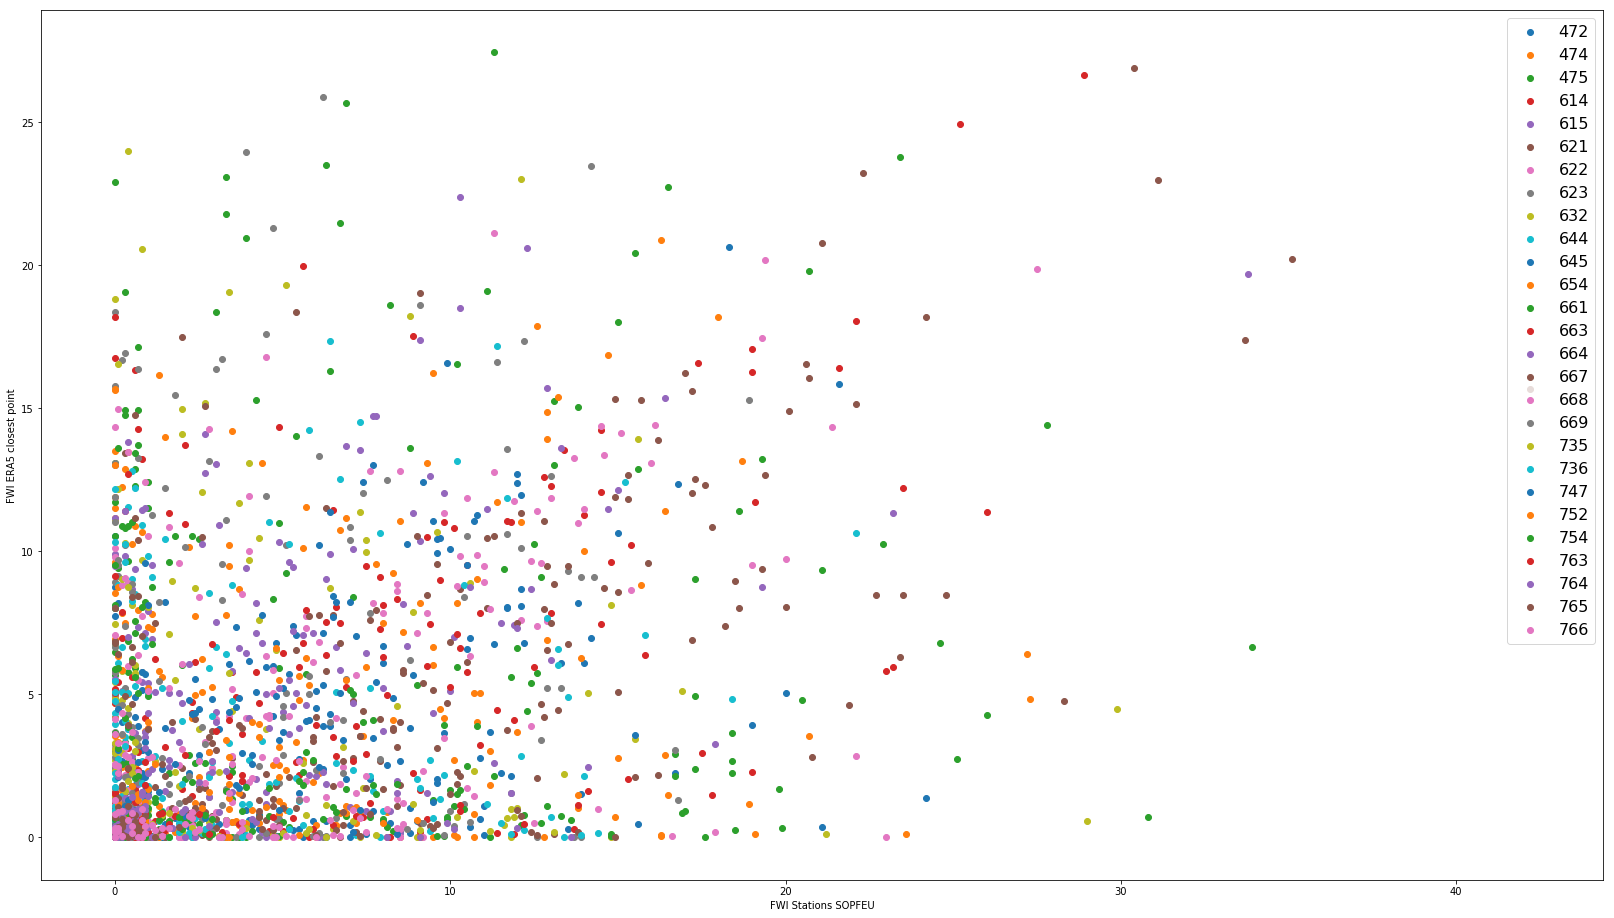

In [17]:
#dataframe_stations.corrwith(other=FWI_kpts_model)
fig=plt.figure(figsize=(28,16), frameon=True) 
for col in dataframe_stations.columns:
    plt.scatter(dataframe_stations[col], FWI_kpts_model[col], label=col)
plt.legend(loc='best', fontsize=16)
plt.xlabel('FWI Stations SOPFEU')
plt.ylabel('FWI ERA5 closest point')
plt.savefig('K:/PROJETS/PROJET_FIRE_INDEX/figures/SOPFEU_Stations_in_Pessamit_Shapefile_Scatter_2018.png', bbox_inches='tight', pad_inches=0.1)
plt.show()


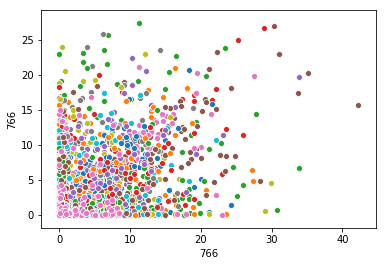

In [18]:
# library &amp; dataset
import seaborn as sns
# plot
for col in dataframe_stations.columns:
    sns.scatterplot(x=dataframe_stations[col], y=FWI_kpts_model[col])
